In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df=pd.read_csv(r'C:\Users\Aleksandra.Arbuzova\Documents\Cookie cats\cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


Описательные статистики по кол-ву игровых раундов

In [3]:
df.describe()[['sum_gamerounds']]

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


Посмотрим более детально по группам

In [4]:
df.groupby('version').describe()[['sum_gamerounds']]

sum_gamerounds                                                      
                 count       mean         std  min  25%   50%   75%      max
version                                                                     
gate_30        44700.0  52.456264  256.716423  0.0  5.0  17.0  50.0  49854.0
gate_40        45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0   2640.0

Явно видно, что в группе gate_30 есть выбросы, что подтверждается и графиком ниже. Для корректной картины аномальные значения необходимо удалить

Text(0.5, 1.0, 'До удаления аномалий')

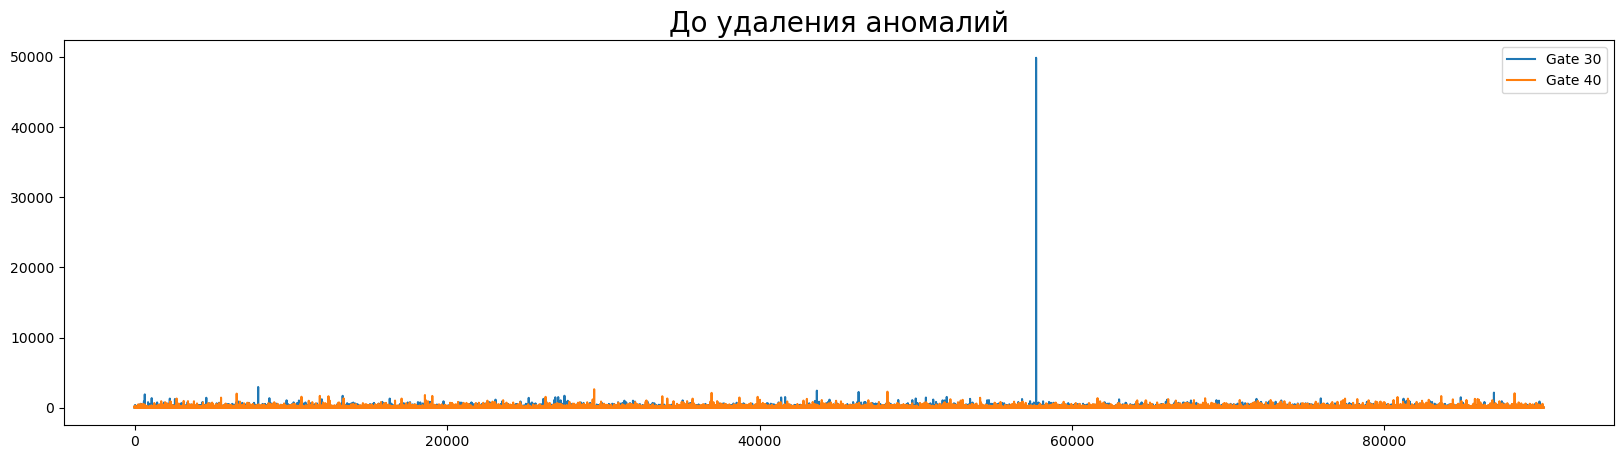

In [5]:
df[df.version == "gate_30"].sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].sum_gamerounds.plot(legend = True, label = "Gate 40", figsize = (20,5))
plt.title('До удаления аномалий', fontsize = 20)

Text(0.5, 1.0, 'После удаления аномалий')

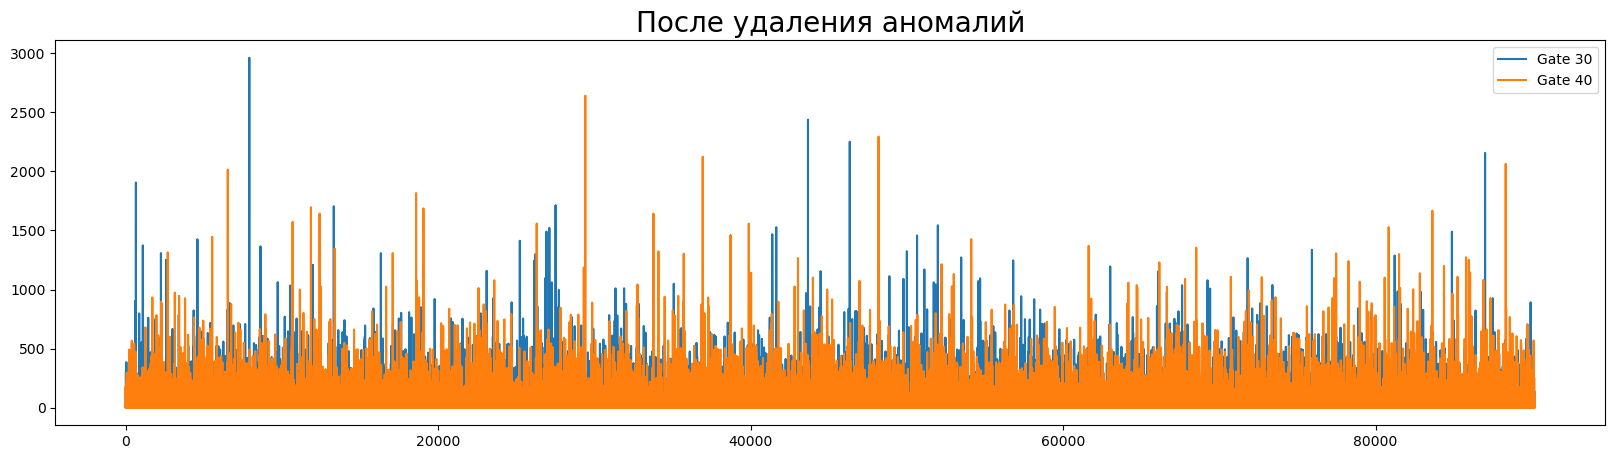

In [6]:
df=df[df['sum_gamerounds']<df['sum_gamerounds'].max()]
df[df.version == "gate_30"].sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].sum_gamerounds.plot(legend = True, label = "Gate 40", figsize = (20,5))
plt.title('После удаления аномалий', fontsize = 20)

In [7]:
df.groupby('version').describe()[['sum_gamerounds']]

sum_gamerounds                                                     
                 count       mean         std  min  25%   50%   75%     max
version                                                                    
gate_30        44699.0  51.342111  102.057598  0.0  5.0  17.0  50.0  2961.0
gate_40        45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0  2640.0

Посмотрим, как кол-во пользователей изменяется в зависимости от кол-ва сыгранных раундов

Text(0.5, 1.0, 'Кол-во пользователей относительно кол-ва раундов')

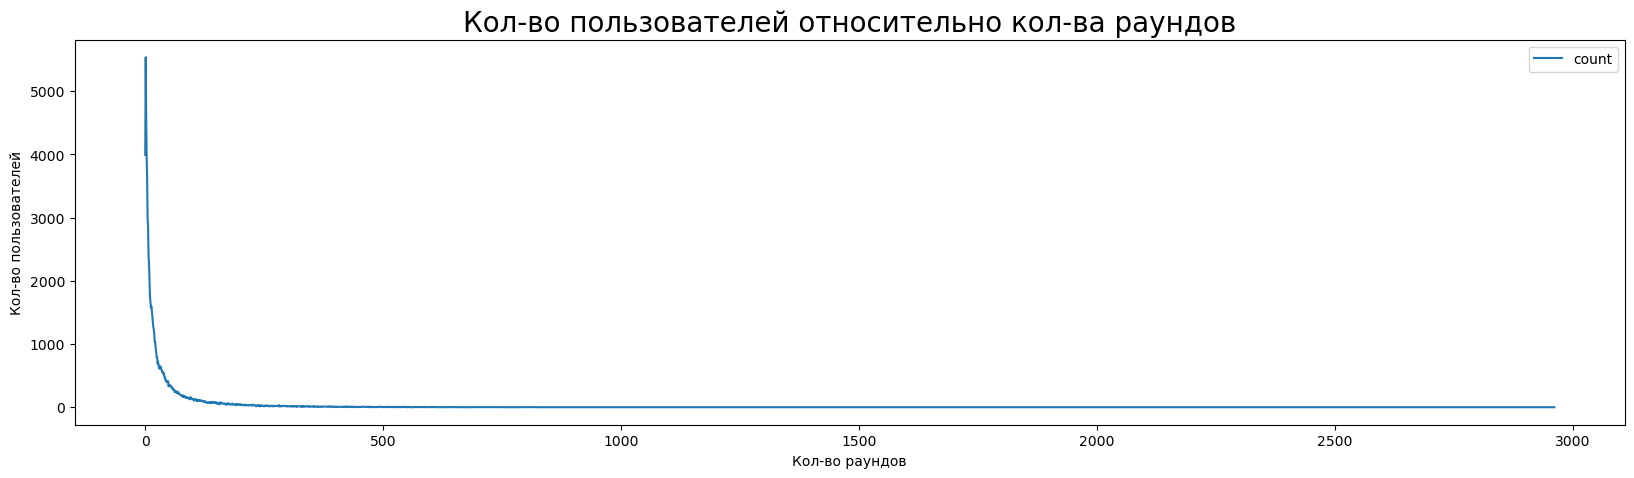

In [8]:
df.groupby('sum_gamerounds').userid.agg(['count']).plot(legend = True, figsize = (20,5))
plt.xlabel('Кол-во раундов')
plt.ylabel('Кол-во пользователей')
plt.title('Кол-во пользователей относительно кол-ва раундов', fontsize = 20)

In [9]:
df.groupby('sum_gamerounds').userid.agg(['count'])

,count
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629
...,...
2251,1
2294,1
2438,1


In [10]:
grouped=df.groupby('sum_gamerounds').userid.agg(['count'])
grouped[grouped['count']>50].index.max()

193

Видим, что 3994 пользователя установили игру, но ни разу не сыграли. 
Видим, что, начиная со 193 раундов, суммарное кол-во пользователей падает с 50 и ниже. Поэтому посмотрим на динамику кол-ва пользователей более детально, ограничиваясь 200 раундами.

Text(0.5, 1.0, 'Кол-во пользователей относительно кол-ва раундов (до 200 раундов)')

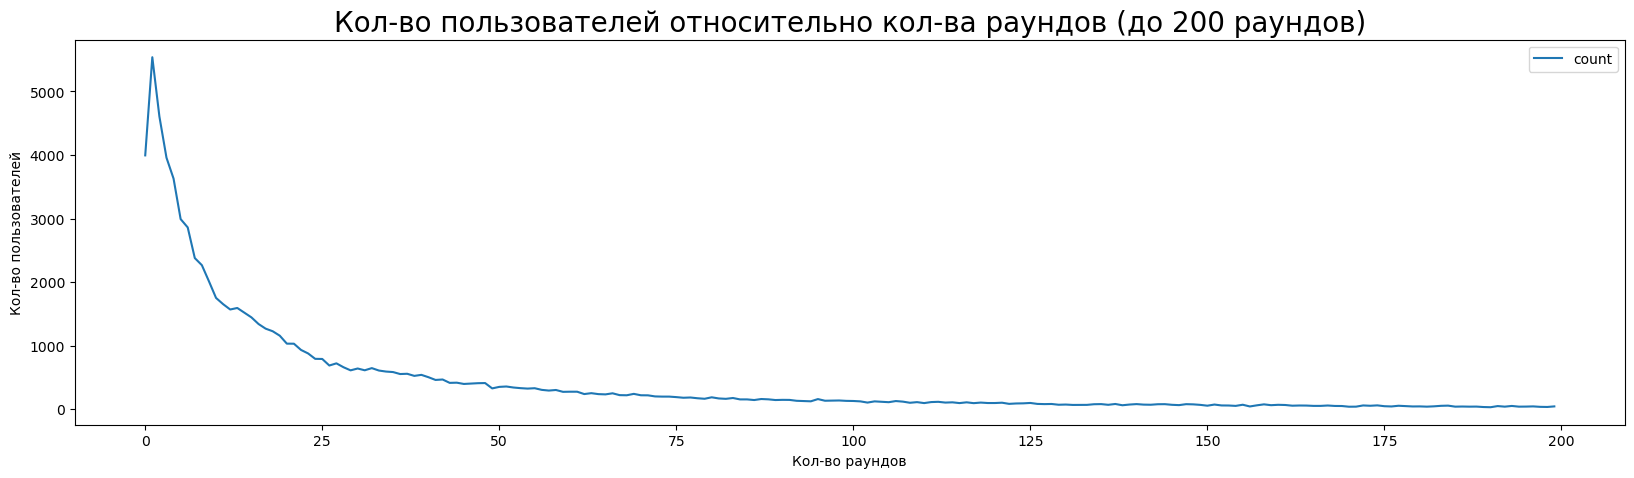

In [11]:
df.groupby('sum_gamerounds').userid.agg(['count'])[:200].plot(legend = True, figsize = (20,5))
plt.xlabel('Кол-во раундов')
plt.ylabel('Кол-во пользователей')
plt.title('Кол-во пользователей относительно кол-ва раундов (до 200 раундов)', fontsize = 20)

In [12]:
df.groupby('version').userid.agg(['count'])

,count
version,
gate_30,44699
gate_40,45489


In [13]:
df[df['retention_1']==True].groupby('version').userid.agg(['count'])

,count
version,
gate_30,20034
gate_40,20119


In [14]:
ret_1_30=20034/44699
ret_1_40=20119/45489

Видим, что 30 уровня достигли 642 человека, 40 уровня достигли 505 человек

In [15]:
df.groupby('sum_gamerounds').userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

Проведем тест для сравнения средних в двух тестовых группах и выявить статистически значимые отличия, если они есть.

In [16]:
df.groupby('version').sum_gamerounds.agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
version,,,,
gate_30,44699,51.342111,17.0,102.057598
gate_40,45489,51.298776,16.0,103.294416


$H_0$: средние двух тестовых групп равны

$H_1$: средние двух тестовых групп различаются

Text(0.5, 0.98, 'Распределение кол-ва раундов в тесстовых группах')

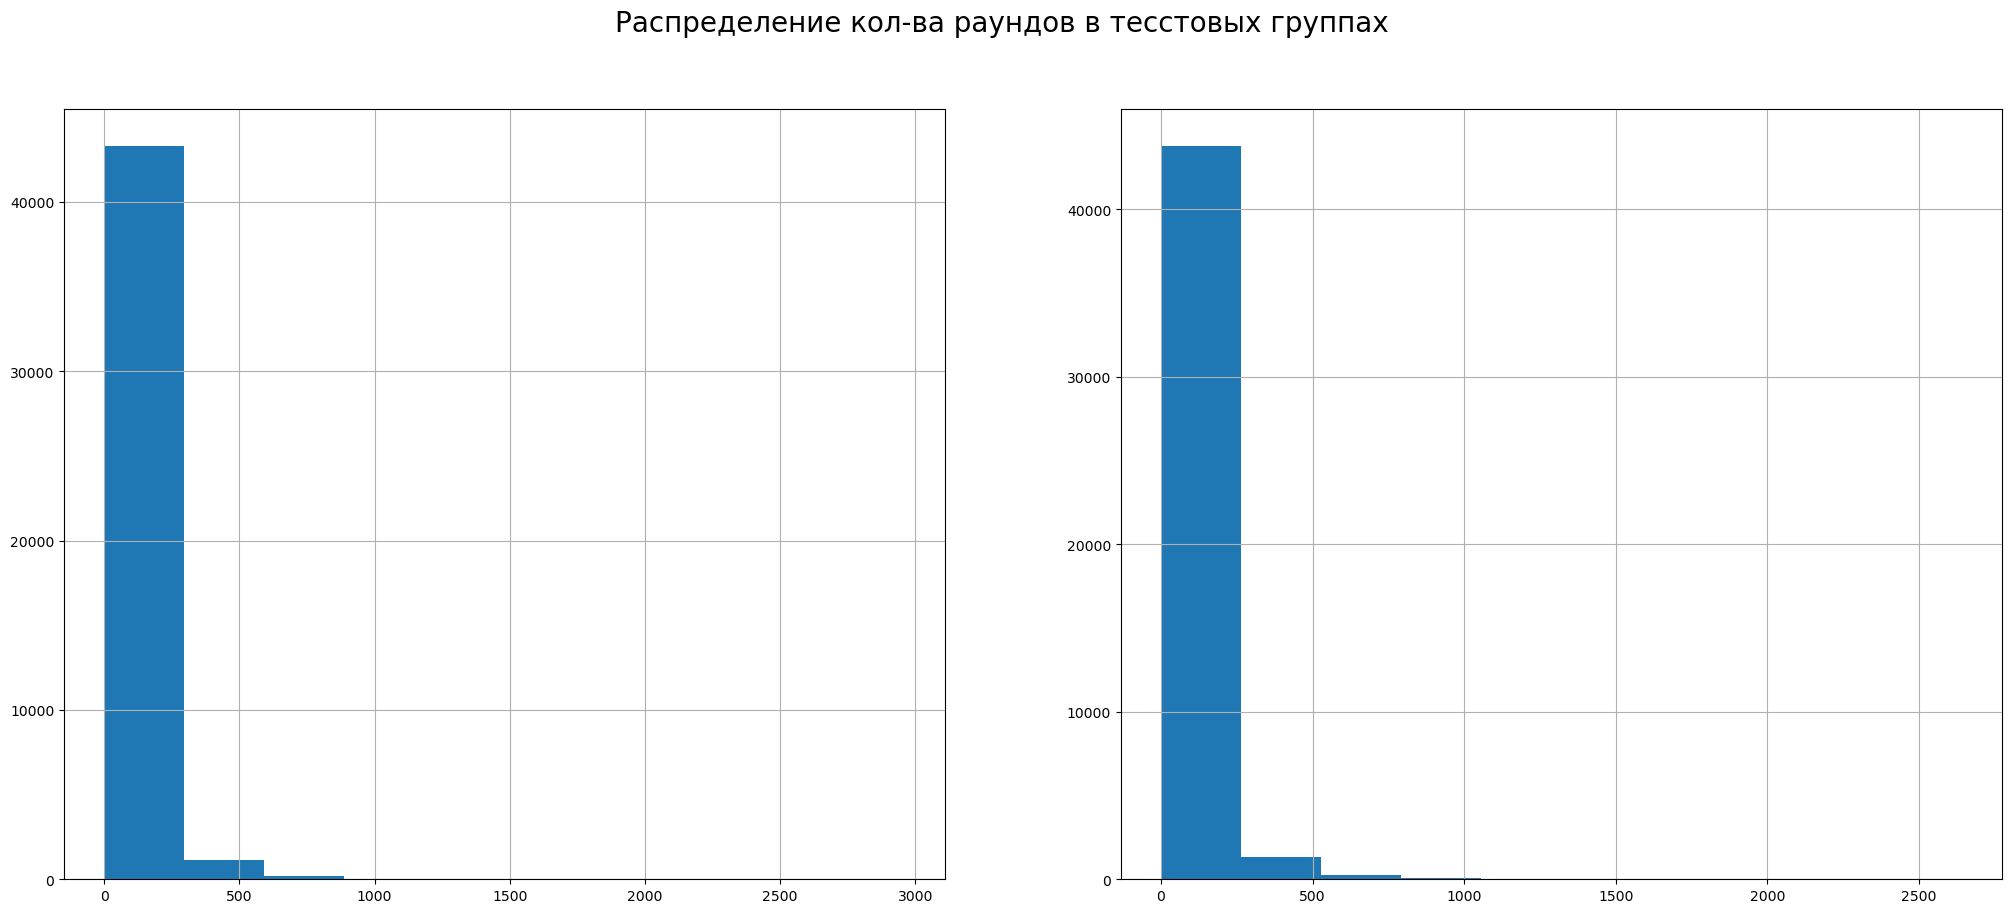

In [17]:
groupA=df[df['version']=='gate_30'].sum_gamerounds
groupB=df[df['version']=='gate_40'].sum_gamerounds
fig, axes = plt.subplots(1, 2, figsize = (25,10))
groupA.hist(ax=axes[0])
groupB.hist(ax=axes[1])
plt.suptitle("Распределение кол-ва раундов в тесстовых группах", fontsize=20)

Видим, что распределения скошенные, не нормальные.

Проведем визуальный тест на нормальность с помощью qq-plot:

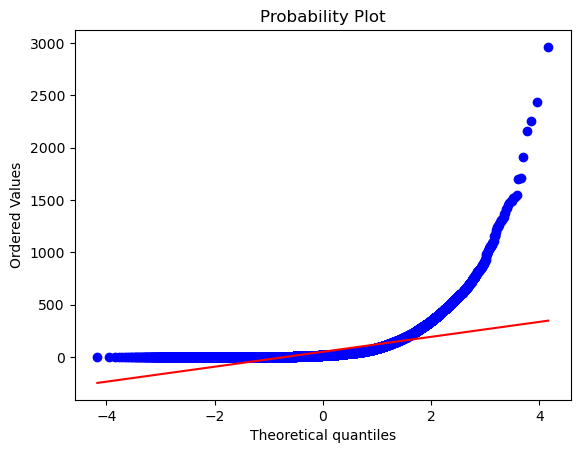

In [18]:
scipy.stats.probplot(groupA, dist = "norm", plot = plt)
plt.show()

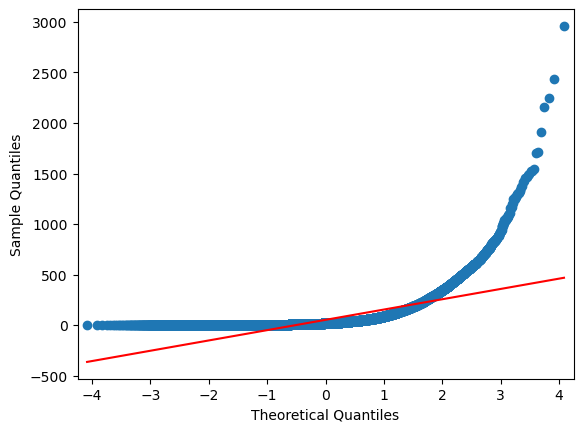

In [20]:
ppplot=sm.ProbPlot(groupA,scipy.stats.norm)
ppplot.qqplot(line='s')
plt.show()

Эти два способа построения qq-plot отличаются масштабом оси X

Второй способ проверить нормальность выборок - критерий Шапиро-Уилка.

In [21]:
shapiroA=scipy.stats.shapiro(groupA)[1]
shapiroB=scipy.stats.shapiro(groupB)[1]
shapiroA, shapiroB

C:\Users\Aleksandra.Arbuzova\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.0, 0.0)

p-value для обеих выборок <0.05, что позволяет отвергнуть нулевую гипотезу о нормальности выборок

Видим, что наши выборки сильно скошены влево, поэтому на таких данных t-тест может не сойтись. Лучше в таком случае применить непараметрический критерий Манна-Уитни

In [102]:
scipy.stats.mannwhitneyu(groupA, groupB, alternative='two-sided')

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

p-value для обеих выборок >0.05, что не позволяет отвергнуть нулевую гипотезу - т.е. статистически значимых различий по кол-ву пройденных раундов между тестовой и контрольной выборкой не наблюдается

Ранее я говорила, что на сильно скошенных данных не желательно использовать t-test, но все же посмотрим, какие результатты он даст:

1-вариант t-теста более ручной (для себя)

In [24]:
x1=df[df['version']=='gate_30'].sum_gamerounds.mean()
x2=df[df['version']=='gate_40'].sum_gamerounds.mean()
sd1=df[df['version']=='gate_30'].sum_gamerounds.std()#по умолчанию уже вычитается 1 степень свободы
sd2=df[df['version']=='gate_40'].sum_gamerounds.std()
n1=df[df['version']=='gate_30'].shape[0]
n2=df[df['version']=='gate_40'].shape[0]

In [25]:
t_stat=(x1-x2)/(np.sqrt(sd1**2/n1 + sd2**2/n2))
t_stat

0.0633742631289196

In [107]:
scipy.stats.t.ppf(0.975, df=n1+n2-2) #критическое значение 

1.9599902890942755

In [26]:
#p_val=2*(1-cdf(|t_stat|)) для двусторонней гипотезы
p_val=2*(1-scipy.stats.t.cdf(x=np.abs(t_stat), df=n1+n2-2))
p_val

0.9494686215422408

2-вариант t-теста (как бы делала на самом деле)

In [27]:
scipy.stats.ttest_ind(df[df['version']=='gate_30'].sum_gamerounds, df[df['version']=='gate_40'].sum_gamerounds)

Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)

Полученное p_value >0.05, что не позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05.


Посмотрим на ретеншн в двух группах:

In [94]:
df_grouped=df.groupby(['version', 'retention_1']).agg({'sum_gamerounds':'count'})
df_grouped

sum_gamerounds
version retention_1                
gate_30 False                 24665
        True                  20034
gate_40 False                 25370
        True                  20119

In [95]:
df_grouped.rename(columns={'sum_gamerounds':'Кол-во польз. по ретеншену'},inplace=True)

In [96]:
df_grouped['Кол-во польз. по версии']=df_grouped.groupby('version')['Кол-во польз. по ретеншену'].transform('sum')

In [98]:
df_grouped['Доля ретеншена']=df_grouped['Кол-во польз. по ретеншену']/df_grouped['Кол-во польз. по версии']

In [99]:
df_grouped

Кол-во польз. по ретеншену  Кол-во польз. по версии  \
version retention_1                                                        
gate_30 False                             24665                    44699   
        True                              20034                    44699   
gate_40 False                             25370                    45489   
        True                              20119                    45489   

                     Доля ретеншена  
version retention_1                  
gate_30 False              0.551802  
        True               0.448198  
gate_40 False              0.557717  
        True               0.442283

Кажется, как будто ретеншн 1 дня примерно одинаковый 